In [1]:
import sys
from pathlib import Path

# Get the folder where this notebook is running
notebook_path = Path().resolve()

# Assume 'src' is at the project root, one level up from the notebook folder
project_root = notebook_path.parent

# Construct the full path to src
src_path = project_root / "src"

# Add src to sys.path if not already there
if str(src_path) not in sys.path:
    sys.path.insert(1, str(src_path))

print(f"Added {src_path} to sys.path")

Added /home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/src to sys.path


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import set_config
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    precision_recall_curve,
    average_precision_score
)

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE



# Configuration

In [3]:
plt.style.use('ggplot')

random_seed = 42

#set output of skllearn to be a pandas dataframe
set_config(transform_output = "pandas")


# Load Data

In [5]:
#train data
x_train = pd.read_csv('../data/cleaned/train/x_train_cleaned.csv')
y_train = pd.read_csv('../data/cleaned/train/y_train.csv')


#test data
x_test  = pd.read_csv('../data/cleaned/test/x_test_cleaned.csv')
y_test  = pd.read_csv('../data/cleaned/test/y_test.csv')



# Train Test Split

In [6]:
#20 % of the data is used for validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, 
                                random_state = random_seed,
                                stratify = y_train)


# Models


In [7]:
def calculating_metrics(y_true, y_pred, y_pred_proba,
                         model_name,
                         print_results = True):
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_proba)

    if print_results:
        print(f"Accuracy:  {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall:    {recall:.4f}")
        print(f"F1 Score:  {f1:.4f}")
        print(f"ROC AUC:   {roc_auc:.4f}")

        print("\nClassification Report:\n")
        print(classification_report(y_val, y_pred))

    results = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc
    }

    results = pd.DataFrame.from_dict(results, orient = 'index')
    results.columns = [model_name]

    return results

In [8]:
def plot_precision_recall_curve(y_true, y_pred_proba):   
    
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)
    avg_precision = average_precision_score(y_val, y_pred_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f"AP = {avg_precision:.2f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## LightGBM

In [9]:
model_lgbm_no_sampling = LGBMClassifier(
    class_weight = 'balanced', 
    scale_pos_weight = 9.0, 
    n_estimators = 100,
    random_state = 42
)
model_lgbm_no_sampling.fit(x_train, y_train)


/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 908, number of negative: 8439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8289
[LightGBM] [Info] Number of data points in the train set: 9347, number of used features: 79
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


LGBMClassifier(class_weight='balanced', random_state=42, scale_pos_weight=9.0)

In [10]:
y_pred = model_lgbm_no_sampling.predict(x_val)
y_pred_proba = model_lgbm_no_sampling.predict_proba(x_val)[:, 1]  # For AUC

lgbm_no_sampling = calculating_metrics(y_val, y_pred, y_pred_proba, 'lgbm_no_sampling')





Accuracy:  0.5494
Precision: 0.1313
Recall:    0.6476
F1 Score:  0.2183
ROC AUC:   0.6644

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.54      0.68      2110
           1       0.13      0.65      0.22       227

    accuracy                           0.55      2337
   macro avg       0.53      0.59      0.45      2337
weighted avg       0.86      0.55      0.64      2337



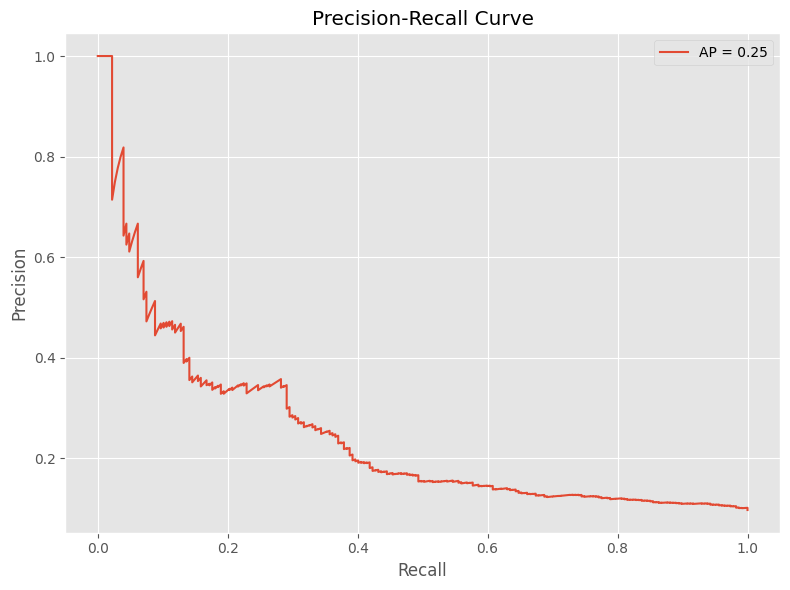

In [103]:
plot_precision_recall_curve(y_val, y_pred_proba)

## Logistic Regression

In [104]:
clf = LogisticRegression(random_state = random_seed,
                        max_iter = 1000, 
                        class_weight = 'balanced')
clf.fit(x_train, y_train)


/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [105]:
y_pred = clf.predict(x_val)
y_pred_proba = clf.predict_proba(x_val)[:, 1]  # For AUC

logistic_no_sampling = calculating_metrics(y_val, y_pred, y_pred_proba, 'logistic_no_sampling')




Accuracy:  0.6093
Precision: 0.1420
Recall:    0.5991
F1 Score:  0.2295
ROC AUC:   0.6525

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.61      0.74      2110
           1       0.14      0.60      0.23       227

    accuracy                           0.61      2337
   macro avg       0.54      0.60      0.48      2337
weighted avg       0.86      0.61      0.69      2337



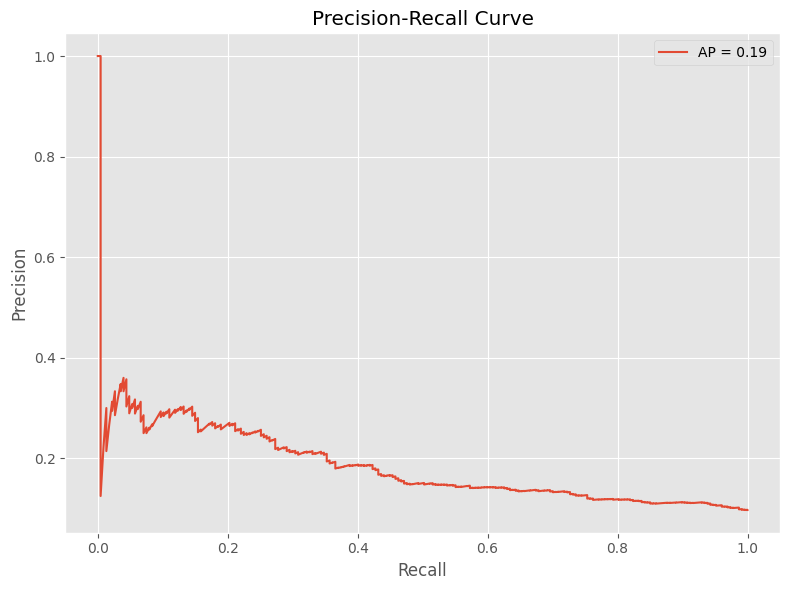

In [106]:
plot_precision_recall_curve(y_val, y_pred_proba)

## Sampling

### Random under-sampling

#### LightGBM

In [107]:
rus = RandomUnderSampler(random_state = random_seed)
x_train_rus_resampled, y_train_rus_resampled = rus.fit_resample(x_train, y_train)

In [108]:
model_lgbm = LGBMClassifier(
    class_weight = 'balanced', 
    n_estimators = 100,
    random_state = 42
)
model_lgbm.fit(x_train_rus_resampled, y_train_rus_resampled)


[LightGBM] [Info] Number of positive: 908, number of negative: 908
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7229
[LightGBM] [Info] Number of data points in the train set: 1816, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


LGBMClassifier(class_weight='balanced', random_state=42)

In [109]:
y_pred = model_lgbm.predict(x_val)
y_pred_proba = model_lgbm.predict_proba(x_val)[:, 1]  # For AUC

lgbm_rus = calculating_metrics(y_val, y_pred, y_pred_proba, 'lgbm_rus')


Accuracy:  0.6179
Precision: 0.1427
Recall:    0.5859
F1 Score:  0.2295
ROC AUC:   0.6427

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.62      0.75      2110
           1       0.14      0.59      0.23       227

    accuracy                           0.62      2337
   macro avg       0.54      0.60      0.49      2337
weighted avg       0.86      0.62      0.70      2337



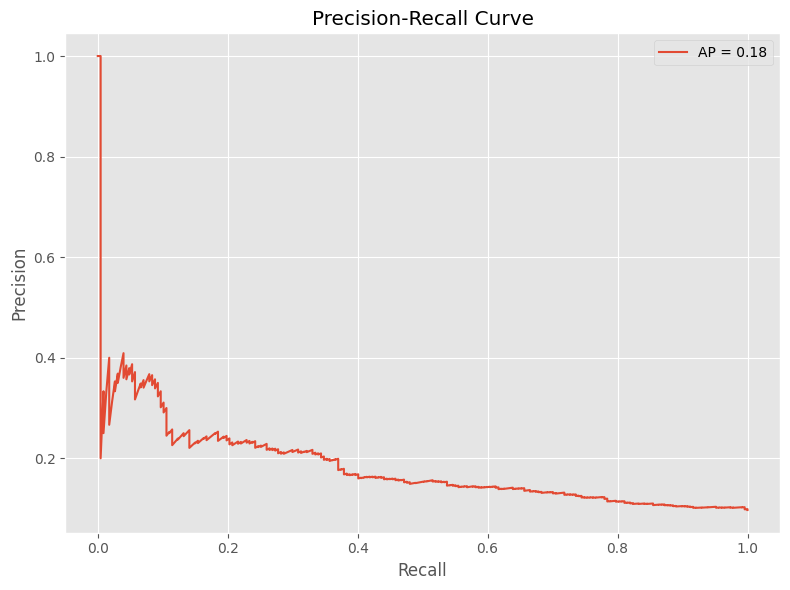

In [110]:
plot_precision_recall_curve(y_val, y_pred_proba)

#### Logistic Regression

In [111]:
clf.fit(x_train_rus_resampled, y_train_rus_resampled)


/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [95]:
y_pred = clf.predict(x_val)
y_pred_proba = clf.predict_proba(x_val)[:, 1]  # For AUC

logistic_rus = calculating_metrics(y_val, y_pred, y_pred_proba, 'logistic_rus')


Accuracy:  0.6110
Precision: 0.1411
Recall:    0.5903
F1 Score:  0.2277
ROC AUC:   0.6473

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.61      0.74      2110
           1       0.14      0.59      0.23       227

    accuracy                           0.61      2337
   macro avg       0.54      0.60      0.48      2337
weighted avg       0.86      0.61      0.69      2337



### Smote

In [112]:
x_train_smote, y_train_smote = SMOTE(random_state = random_seed).fit_resample(x_train, y_train)


##### LightGBM

In [113]:
model_lgbm.fit(x_train_smote, y_train_smote)


/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 8439, number of negative: 8439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14277
[LightGBM] [Info] Number of data points in the train set: 16878, number of used features: 79
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(class_weight='balanced', random_state=42)

In [114]:
y_pred = clf.predict(x_val)
y_pred_proba = clf.predict_proba(x_val)[:, 1]  # For AUC

lgbm_smote = calculating_metrics(y_val, y_pred, y_pred_proba, 'lightgbm_smote')


Accuracy:  0.6110
Precision: 0.1411
Recall:    0.5903
F1 Score:  0.2277
ROC AUC:   0.6473

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.61      0.74      2110
           1       0.14      0.59      0.23       227

    accuracy                           0.61      2337
   macro avg       0.54      0.60      0.48      2337
weighted avg       0.86      0.61      0.69      2337



#### Logistic Regression

In [115]:
clf.fit(x_train_smote, y_train_smote)

/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [116]:
y_pred = clf.predict(x_val)
y_pred_proba = clf.predict_proba(x_val)[:, 1]  # For AUC

logistic_smote = calculating_metrics(y_val, y_pred, y_pred_proba, 'logistic_rus')

Accuracy:  0.6076
Precision: 0.1361
Recall:    0.5683
F1 Score:  0.2196
ROC AUC:   0.6458

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.61      0.74      2110
           1       0.14      0.57      0.22       227

    accuracy                           0.61      2337
   macro avg       0.53      0.59      0.48      2337
weighted avg       0.85      0.61      0.69      2337



## Feature Selection

Model-based feature importance

### Complete dataset

In [126]:
model_selector_rus = LGBMClassifier(
    class_weight = 'balanced', 
    n_estimators = 100,
    random_state = 42
)
model_selector_rus.fit(x_train_rus_resampled, y_train_rus_resampled)

[LightGBM] [Info] Number of positive: 908, number of negative: 908
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7229
[LightGBM] [Info] Number of data points in the train set: 1816, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


LGBMClassifier(class_weight='balanced', random_state=42)

In [127]:
selector = SelectFromModel(model_selector_rus, threshold="median", prefit=True)
x_train_rus_selected = selector.transform(x_train_rus_resampled)
x_val_selected = selector.transform(x_val)
x_test_selected = selector.transform(x_test)

/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [ ]:
model_selected_rus = LGBMClassifier(
    class_weight = 'balanced', 
    n_estimators = 100,
    random_state = 42
)

model_selected_rus.fit(x_train_selected, y_train)

[LightGBM] [Info] Number of positive: 908, number of negative: 8439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8130
[LightGBM] [Info] Number of data points in the train set: 9347, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


LGBMClassifier(class_weight='balanced', random_state=42, scale_pos_weight=9.0)

In [123]:
y_pred = model_selected_no_sampling.predict(x_val_selected)
y_pred_proba = model_selected_no_sampling.predict_proba(x_val_selected)[:, 1]  # For AUC
lgbm_no_sampling_selected = calculating_metrics(y_val, y_pred, y_pred_proba, 'lightgbm_ns_selected')

Accuracy:  0.5477
Precision: 0.1366
Recall:    0.6872
F1 Score:  0.2279
ROC AUC:   0.6696

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.53      0.68      2110
           1       0.14      0.69      0.23       227

    accuracy                           0.55      2337
   macro avg       0.54      0.61      0.45      2337
weighted avg       0.86      0.55      0.64      2337



### Random UnderSampled

In [76]:
 selector.transform(x_train_rus_resampled)


IndexError: Boolean index has wrong length: 44 instead of 83

## Results - Comparisson

In [40]:
results = pd.concat([lgbm_no_sampling, lgbm_rus, lgbm_smote, lgbm_no_sampling_selected, 
                logistic_no_sampling, logistic_rus, logistic_smote], axis = 1)

In [41]:
results

,lgbm_no_sampling,lgbm_rus,lightgbm_smote,lightgbm_ns_selected,logistic_no_sampling,logistic_rus,logistic_rus
accuracy,0.549422,0.617886,0.607617,0.547711,0.609328,0.611040,0.607617
precision,0.131250,0.142704,0.136076,0.136602,0.141962,0.141053,0.136076
recall,0.647577,0.585903,0.568282,0.687225,0.599119,0.590308,0.568282
f1,0.218263,0.229508,0.219574,0.227904,0.229536,0.227698,0.219574
roc_auc,0.664352,0.642667,0.645771,0.669562,0.652544,0.647329,0.645771
